# Cubic equations of state

In [1]:
using Pkg
Pkg.activate("..")
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot

  Activating project at `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/University/UROP/SAFT_codes/Clapeyron`


PyPlot

In this notebook, we will be giving examples of how one can use cubic equations of state in `Clapeyron.jl`, along with the extremely easy ways one can customise these using:
-  $\alpha$-functions: These are meant to improve the modelling of pure VLE properties although modifications such as Boston-Matthias can have a significant impact on multi-component VLE. 
- Volume translation methods: Cubics generally don't predict very accurate liquid densities, particularly for hydrogen-bonding fluids. Volume translation improves the accuracy of this property without affecting the accuracy of VLE properties.
- Mixing rules: To model multi-component systems, mixing rules are required to obtain the one-fluid-mixture parameters. These can vary greatly in terms of accuracy and, in some cases, may require an additional model.

## Vapour-liquid equilibria of water

We'll be giving an example of how to modify the $\alpha$-functions and volume-translation methods for a cubic model using the vapour-liquid equilibrium of water.

As a first step, we need to generate the models:

In [2]:
# Generating the models
model1 = RK(["water"])
model2 = PatelTeja(["water"])
model3 = PR(["water"];alpha=TwuAlpha)
model4 = PR(["water"];alpha=TwuAlpha,translation=RackettTranslation)

# Concatenating them into one list
models = [model1,model2,model3,model4];

As we can see, all that we need to do to modify the $\alpha$-function or volume translation method is use the optional arguments `alpha` and `translation`.

We can now obtain the VLE envelope of water. We first need the critical point which can be obtained using `crit_pure`:

In [3]:
# Obtaining all of their critical points
crit = crit_pure.(models);

Subsequently, we can obtain the saturation curve using `saturation_pressure`:

In [5]:
# Obtaining the saturation curve
N = 300
T = zeros(N,4)
p = zeros(N,4)
v_l = zeros(N,4)
v_v = zeros(N,4)
for i ∈ 1:4
    T[:,i] = range(285,crit[i][1],length=N)
    sat = saturation_pressure.(models[i],T[:,i])
    p[:,i] = [sat[i][1] for i ∈ 1:N]
    v_l[:,i] = [sat[i][2] for i ∈ 1:N]
    v_v[:,i] = [sat[i][3] for i ∈ 1:N]
end

Collecting some data from the NIST Chemistry Webbook

In [6]:
T_exp = [300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,647.096]

p_exp = [0.0035368,0.010546,0.027188,0.062194,0.12885,0.24577,0.4373,0.73367,1.1709,1.7905,2.6392,3.769,5.2369,7.1062,9.448,12.345,15.901,20.265,22.064]

ρ_l_exp = [55.315,54.919,54.371,53.698,52.918,52.038,51.064,49.994,48.824,47.545,46.145,44.603,42.889,40.956,38.725,36.048,32.577,26.729,17.873728]

ρ_v_exp = [0.0014204,0.0039778,0.0096808,0.021014,0.041537,0.076014,0.13055,0.21276,0.33209,0.50035,0.73265,1.0491,1.478,2.062,2.872,4.0434,5.9009,9.8331,17.873728];

Plotting:

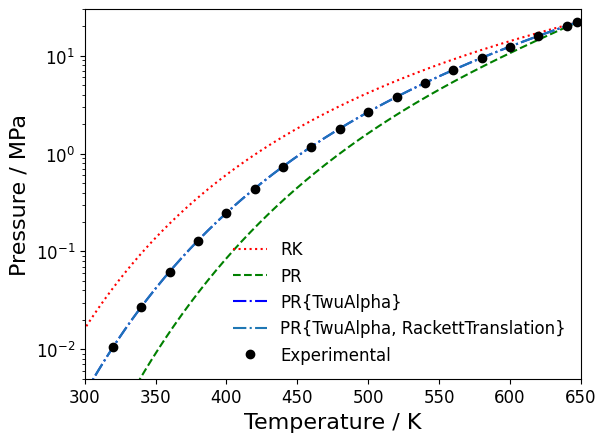

In [8]:
# Plotting p-T curve
plt.clf()
plt.semilogy(T[:,1],p[:,1] ./1e6,label="RK",linestyle=":",color="r")
plt.semilogy(T[:,2],p[:,2] ./1e6,label="PR",linestyle="--",color="g")
plt.semilogy(T[:,3],p[:,3] ./1e6,label="PR{TwuAlpha}",linestyle="-.",color="b")
plt.semilogy(T[:,4],p[:,4] ./1e6,label="PR{TwuAlpha, RackettTranslation}",linestyle="-.")
plt.semilogy(T_exp,p_exp,label="Experimental",marker="o",linestyle="",color="k")
# Create a legend of all the existing plots using their labels as names
plt.legend(loc="lower right",frameon=false,fontsize=12) 
plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([300,650])
plt.ylim([5e-3,3e1])
display(plt.gcf())

As we can see above, the addition of volume translation hasn't affected the predicted saturation curve, but the modified $\alpha$-function has. Twu _et al._ fitted their function against experimental data; it isn't so surprising then that their predictions are the most accurate.

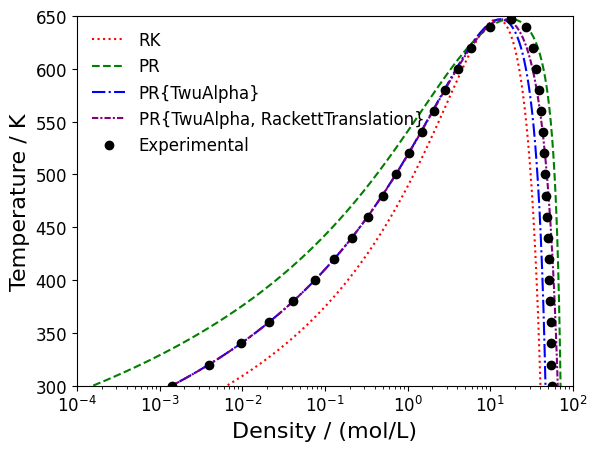

In [9]:
# Plotting rho-T envelope
plt.clf()
plt.semilogx(1e-3 ./v_l[:,1],T[:,1],label="RK",linestyle=":",color="r")
plt.semilogx(1e-3 ./v_v[:,1],T[:,1],label="",linestyle=":",color="r")
plt.semilogx(1e-3 ./v_l[:,2],T[:,2],label="PR",linestyle="--",color="g")
plt.semilogx(1e-3 ./v_v[:,2],T[:,2],label="",linestyle="--",color="g")
plt.semilogx(1e-3 ./v_l[:,3],T[:,3],label="PR{TwuAlpha}",linestyle="-.",color="b")
plt.semilogx(1e-3 ./v_v[:,3],T[:,3],label="",linestyle="-.",color="b")
plt.semilogx(1e-3 ./v_l[:,4],T[:,4],label="PR{TwuAlpha, RackettTranslation}",linestyle=(0, (3, 1, 1, 1)),color="purple")
plt.semilogx(1e-3 ./v_v[:,4],T[:,4],label="",linestyle=(0, (3, 1, 1, 1)),color="purple")
plt.semilogx(ρ_l_exp,T_exp,label="Experimental",marker="o",linestyle="",color="k")
plt.semilogx(ρ_v_exp,T_exp,label="",marker="o",linestyle="",color="k")

plt.legend(loc="upper left",frameon=false,fontsize=12) 
plt.xlabel("Density / (mol/L)",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([1e-4,1e2])
plt.ylim([300,650])
display(plt.gcf())

In our $\rho-T$ envelope, we can see that the volume translation has indeed improve the predictions of our liquid volume. The $\alpha$-function doesn't appear to have as significant an impact.

## $p-xy$ evenlope for carbon dioxide+carbon monoxide


We use this case to illustrate how modifying an $\alpha$-function can also have an impact on predicted VLE of a binary mixture, even when one component is supercritical. 

Once again, we generate the models first:

In [2]:
model1 = PR(["carbon monoxide","carbon dioxide"])
model2 = PR(["carbon monoxide","carbon dioxide"];alpha=BMAlpha)
model3 = PR(["carbon monoxide","carbon dioxide"];mixing=KayRule)
model4 = VTPR(["carbon monoxide","carbon dioxide"])
model5 = VTPR(["carbon monoxide","carbon dioxide"];alpha=BMAlpha)

models = [model1,model2,model3,model4,model5];

As we can see, we can also modify the mixing rule by using the optional argument `mixing`.

Since carbon monoxide is supercritical, the VLE envelope with never reach a composition of $x_\text{CO}=1$; as such, we limit the range of compositions up to the critical point of the mixture which has to be determined manually. We can then obtain the VLE envelope using the `bubble_pressure` function:

In [5]:
N = 400

T = 218.15
x1 = range(1e-5,0.518,length=N)
x2 = range(1e-5,0.512,length=N)
x3 = range(1e-5,0.655,length=N)
x4 = range(1e-4,0.56,length=N)
x5 = range(1e-5,0.57,length=N)
x = hcat(x1,x2,x3,x4,x5)
X1 = Clapeyron.FractionVector.(x1)
X2 = Clapeyron.FractionVector.(x2)
X3 = Clapeyron.FractionVector.(x3)
X4 = Clapeyron.FractionVector.(x4)
X5 = Clapeyron.FractionVector.(x5)
X = [X1,X2,X3,X4,X5]

y = zeros(800,5)
p = zeros(800,5)
for i ∈ 1:5
    v0 = Clapeyron.x0_bubble_pressure(models[i],T,X[i][1])
    for j ∈ 1:400
        bub = bubble_pressure(models[i],T,X[i][j],v0=v0)
        p[j,i] = bub[1]
        p[800-j+1,i] = bub[1]
        y[j,i] = bub[4][1]
        y[800-j+1,i] = x[j,i]
        v0 = [log10(bub[2]),log10(bub[3]),bub[4][1],bub[4][2]]
    end
end

1

2

3

4

5



The above is an example of how one can generate these figures quickly (and smoothly). We can re-use the solution from the previous iteration as an initial guess to the next iteration.

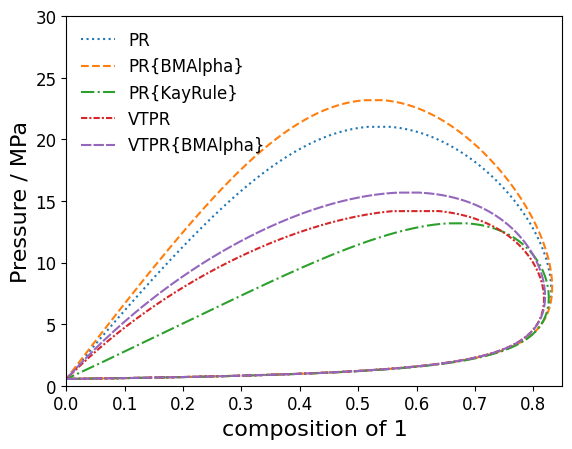

In [6]:
plt.clf()
plt.plot(y[:,1],p[:,1]./1e6,label="PR",linestyle=":")
plt.plot(y[:,2],p[:,2]./1e6,label="PR{BMAlpha}",linestyle="--")
plt.plot(y[:,3],p[:,3]./1e6,label="PR{KayRule}",linestyle="-.")
plt.plot(y[:,4],p[:,4]./1e6,label="VTPR",linestyle=(0, (3, 1, 1, 1)))
plt.plot(y[:,5],p[:,5]./1e6,label="VTPR{BMAlpha}",linestyle=(0, (5, 1)))
plt.legend(loc="upper left",frameon=false,fontsize=12) 
plt.xlabel("composition of 1",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,0.85])
plt.ylim([0,30])
display(plt.gcf())

As we can see, the use of the Boston-Matthias $\alpha$-function in the above example can greatly improve our predictions of the VLE; this is primarily because the standard $\alpha$-function in Peng-Robinson begins to behave unphysically above the critical point (previous studies have highlighted that it can predict a second VLE region at high temperatures).

## $p-xy$ diagram of methanol+cyclohexane

We use this case to illustrate the impact of different mixing rules on our predicted VLE behaviour for the methanol+cyclohexane mixture.

Once again, we generate the models first:

In [42]:
model1 = SRK(["methanol","benzene"])
model2 = SRK(["methanol","benzene"];mixing=HVRule,activity=UNIFAC)
model3 = SRK(["methanol","benzene"];mixing=MHV2Rule,activity=UNIFAC)
model4 = SRK(["methanol","benzene"];mixing=MHV2Rule,activity=COSMOSAC02)
model5 = PSRK(["methanol","benzene"])

models = [model1,model2,model3,model4,model5];

As shown above, whilst we can specify the mixing rule using the optional argument `mixing`. However, for some mixing rules, we also need to specify an activity model, which can be specified using the optional argument `activity`.

Since both components are sub-critical, we can scan the full composition space (once again, re-using initial guesses):

In [45]:
T = 433.15
N = 200
x = range(1e-5,1-1e-5,length=N)
X = Clapeyron.FractionVector.(x)

y = zeros(400,5)
p = zeros(400,5)
for i ∈ 1:5
    v0 = Clapeyron.x0_bubble_pressure(models[i],T,X[1])
    for j ∈ 1:200
        bub = bubble_pressure(models[i],T,X[j],v0=v0)
        p[j,i] = bub[1]
        p[400-j+1,i] = bub[1]
        y[j,i] = bub[4][1]
        y[400-j+1,i] = x[j]
        v0 = [log10(bub[2]),log10(bub[3]),bub[4][1],bub[4][2]]
    end
end

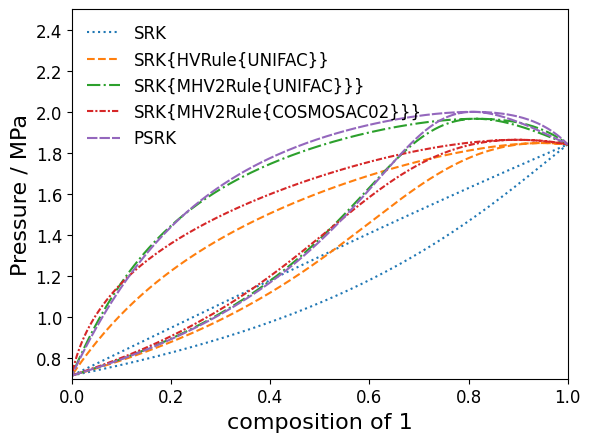

In [46]:
plt.clf()
plt.plot(y[:,1],p[:,1]./1e6,label="SRK",linestyle=":")
plt.plot(y[:,2],p[:,2]./1e6,label="SRK{HVRule{UNIFAC}}",linestyle="--")
plt.plot(y[:,3],p[:,3]./1e6,label="SRK{MHV2Rule{UNIFAC}}}",linestyle="-.")
plt.plot(y[:,4],p[:,4]./1e6,label="SRK{MHV2Rule{COSMOSAC02}}}",linestyle=(0, (3, 1, 1, 1)))
plt.plot(y[:,5],p[:,5]./1e6,label="PSRK",linestyle=(0, (5, 1)))
plt.legend(loc="upper left",frameon=false,fontsize=12) 
plt.xlabel("composition of 1",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0.7,2.5])
plt.xlim([0,1])
display(plt.gcf())

We can see the drastic impact of changing the mixing rule and activity model on the predicted VLE behaviour. We can go from predicting no azeotrope using the default van der Waals one-fluid mixing rule, to over-predicting the azeotrope using even the high-accuracy PSRK equation of state